<a href="https://colab.research.google.com/github/yeoseungjun07/sangsan-highschool-No.1/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [46]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'AXREKARESQEKKKYQAKWSHKAQATGQKPHCKRKWRTWFILSLPHLIWFPSPSSSSLCFSVSLSLCLSPLLLQCVTRREYNWKIKSCRSSSVSSSSVSSYSVSPGIFPELITPPPVDRLGVRWMCQGTCG' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = '6VSB_antibody' #@param {type:"string'}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv") # Moved this line here
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname 6VSB_antibody_cd21c_2
sequence AXREKARESQEKKKYQAKWSHKAQATGQKPHCKRKWRTWFILSLPHLIWFPSPSSSSLCFSVSLSLCLSPLLLQCVTRREYNWKIKSCRSSSVSSSSVSSYSVSPGIFPELITPPPVDRLGVRWMCQGTCG
length 131


In [39]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

CPU times: user 20 µs, sys: 10 µs, total: 30 µs
Wall time: 33.1 µs


In [40]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [41]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-08-04 12:36:25,518 Running on GPU
2025-08-04 12:36:25,853 Found 5 citations for tools or databases
2025-08-04 12:36:25,853 Query 1/1: 6VSB_antibody_cd21c (length 131)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-08-04 12:36:26,135 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:10 remaining: ?]

2025-08-04 12:36:36,405 Sleeping for 5s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:15 remaining: ?]

2025-08-04 12:36:41,678 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:26 remaining: ?]

2025-08-04 12:36:51,942 Sleeping for 9s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:35 remaining: ?]

2025-08-04 12:37:01,210 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:42 remaining: ?]

2025-08-04 12:37:08,484 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:49 remaining: ?]

2025-08-04 12:37:15,754 Sleeping for 5s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:55 remaining: ?]

2025-08-04 12:37:21,019 Sleeping for 6s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 01:01 remaining: ?]

2025-08-04 12:37:27,286 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 01:08 remaining: ?]

2025-08-04 12:37:34,581 Sleeping for 9s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 01:17 remaining: ?]

2025-08-04 12:37:43,855 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 01:25 remaining: ?]

2025-08-04 12:37:51,126 Sleeping for 8s. Reason: PENDING


RUNNING:   5%|▌         | 8/150 [elapsed: 01:33 remaining: 27:40]

2025-08-04 12:37:59,394 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 18/150 [elapsed: 01:43 remaining: 10:41]

2025-08-04 12:38:09,678 Sleeping for 7s. Reason: RUNNING


RUNNING:  17%|█▋        | 25/150 [elapsed: 01:51 remaining: 07:00]

2025-08-04 12:38:16,965 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 02:01 remaining: 00:00]


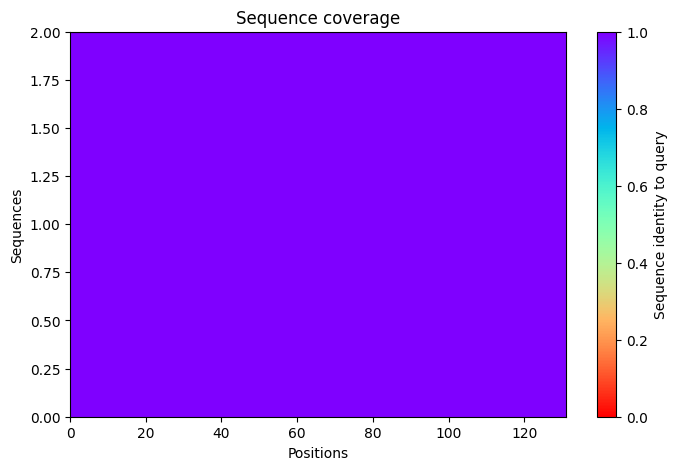

2025-08-04 12:38:28,146 Setting max_seq=2, max_extra_seq=1
2025-08-04 12:39:00,906 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=36.9 pTM=0.199
2025-08-04 12:39:19,360 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=34.8 pTM=0.203 tol=7.26
2025-08-04 12:39:20,776 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=33.6 pTM=0.195 tol=6.12
2025-08-04 12:39:22,209 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=33.3 pTM=0.205 tol=5.89
2025-08-04 12:39:22,210 alphafold2_ptm_model_1_seed_000 took 42.6s (3 recycles)


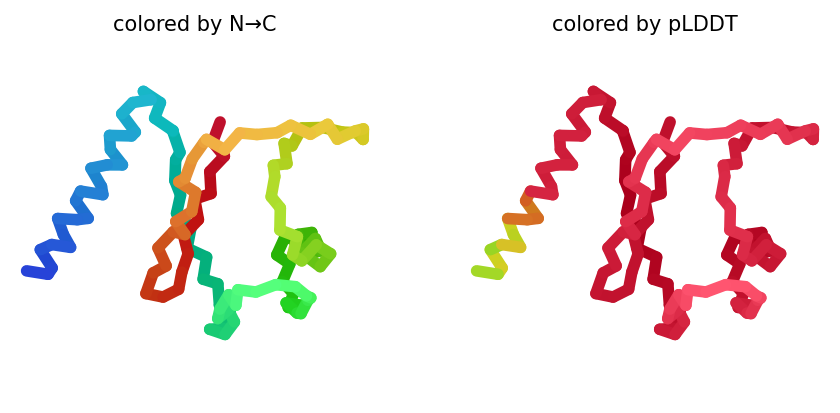

2025-08-04 12:39:23,839 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=34.2 pTM=0.176
2025-08-04 12:39:25,266 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=34.2 pTM=0.166 tol=5.74
2025-08-04 12:39:26,691 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=34.5 pTM=0.16 tol=3.2
2025-08-04 12:39:28,118 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=35.5 pTM=0.157 tol=3.44
2025-08-04 12:39:28,119 alphafold2_ptm_model_2_seed_000 took 5.7s (3 recycles)


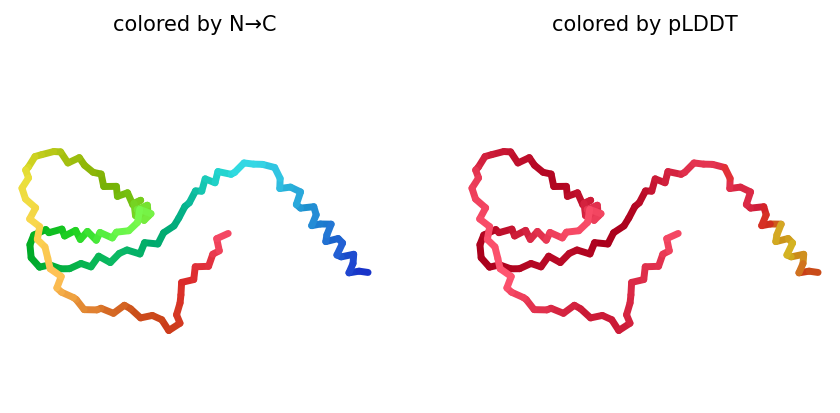

2025-08-04 12:39:29,660 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=34 pTM=0.194
2025-08-04 12:39:31,090 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=33.3 pTM=0.187 tol=3.62
2025-08-04 12:39:32,524 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=34.2 pTM=0.188 tol=3.45
2025-08-04 12:39:33,972 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=33.3 pTM=0.186 tol=1.41
2025-08-04 12:39:33,972 alphafold2_ptm_model_3_seed_000 took 5.7s (3 recycles)


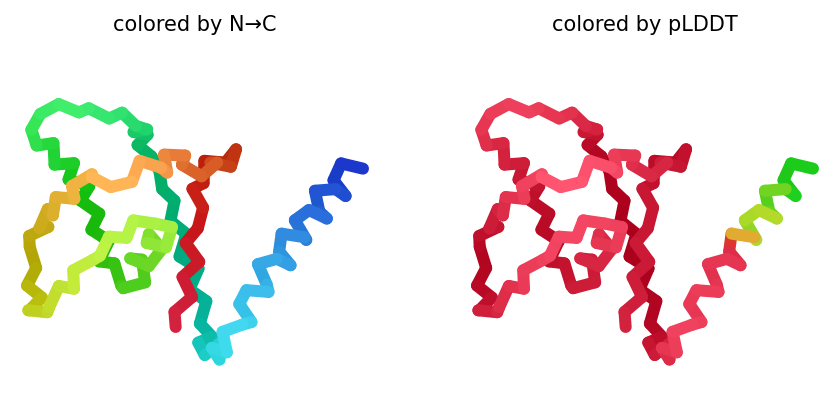

2025-08-04 12:39:35,595 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=31.3 pTM=0.182
2025-08-04 12:39:37,033 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=29.9 pTM=0.18 tol=7.68
2025-08-04 12:39:38,475 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=30.6 pTM=0.185 tol=6.07
2025-08-04 12:39:39,913 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=30.8 pTM=0.187 tol=2.83
2025-08-04 12:39:39,914 alphafold2_ptm_model_4_seed_000 took 5.8s (3 recycles)


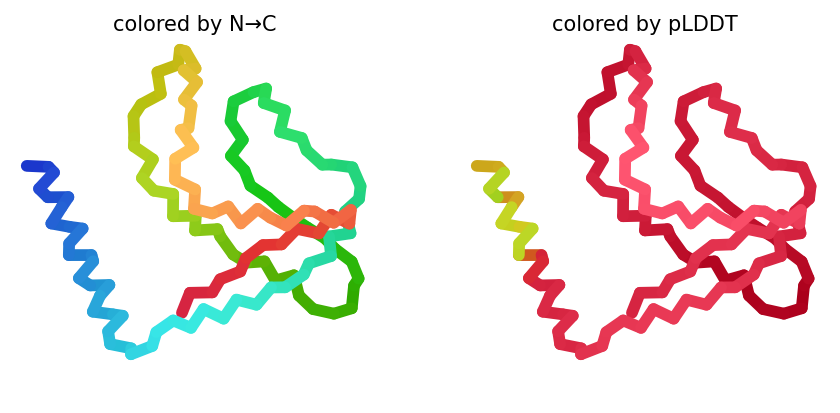

2025-08-04 12:39:41,487 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=31 pTM=0.17
2025-08-04 12:39:42,931 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=30.7 pTM=0.166 tol=6.86
2025-08-04 12:39:44,376 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=31.2 pTM=0.173 tol=7.99
2025-08-04 12:39:45,839 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=31.7 pTM=0.181 tol=2.25
2025-08-04 12:39:45,840 alphafold2_ptm_model_5_seed_000 took 5.8s (3 recycles)


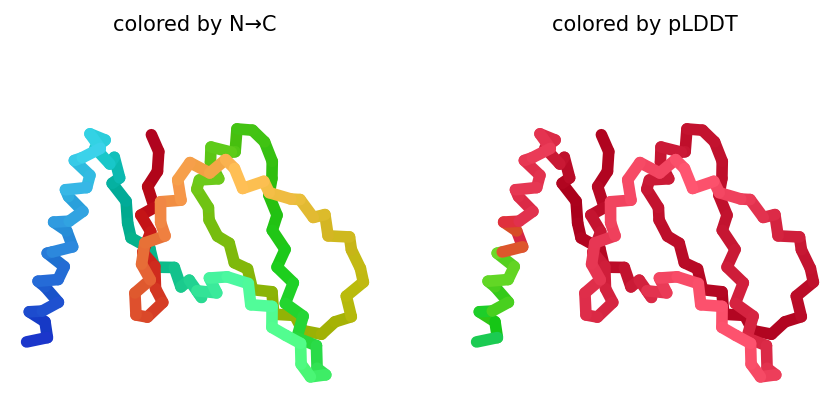

2025-08-04 12:39:46,007 reranking models by 'plddt' metric
2025-08-04 12:39:46,008 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=35.5 pTM=0.157
2025-08-04 12:39:46,008 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=33.3 pTM=0.186
2025-08-04 12:39:46,008 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=33.3 pTM=0.205
2025-08-04 12:39:46,009 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=31.7 pTM=0.181
2025-08-04 12:39:46,009 rank_005_alphafold2_ptm_model_4_seed_000 pLDDT=30.8 pTM=0.187
2025-08-04 12:39:47,817 Done


0

In [54]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

# Redefine @param variables from previous cells for robustness
# From cell kOblAo-xetgx
query_sequence = 'AXREKARESQEKKKYQAKWSHKAQATGQKPHCKRKWRTWFILSLPHLIWFPSPSSSSLCFSVSLSLCLSPLLLQCVTRREYNWKIKSCRSSSVSSSSVSSYSVSPGIFPELITPPPVDRLGVRWMCQGTCG' #@param {type:"string"}
jobname = '6VSB_antibody' #@param {type:"string'}
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
template_mode = "none" #@param ["none", "pdb100","custom"]

# From cell C2_sh2uAonJH
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}

# From cell ADDuaolKmjGW
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
calc_extra_ptm = False #@param {type:"boolean"}
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
dpi = 200 #@param {type:"integer"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# use_amber and other variables derived from @param need to be defined after @params
use_amber = num_relax > 0
use_templates = template_mode != "none" # Derived from template_mode

# Use python_version from previous cell kOblAo-xetgx
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

# Use custom_template_path from previous cell kOblAo-xetgx
# This requires cell kOblAo-xetgx to be run first, especially if template_mode is "custom"
# If template_mode is "custom", custom_template_path is set in kOblAo-xetgx
# If template_mode is "none" or "pdb100", custom_template_path is None

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

# Use jobname and queries_path from kOblAo-xetgx
result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

# Redefine variables from previous cells - REMOVED REDEFINITION OF query_sequence, jobname, queries_path
# From cell C2_sh2uAonJH
# msa_mode and pair_mode are now redefined as @param at the top

# model_type, num_recycles, recycle_early_stop_tolerance, relax_max_iterations,
# pairing_strategy, calc_extra_ptm, max_msa, num_seeds, use_dropout, save_all,
# save_recycles, save_to_google_drive, dpi are now redefined as @param at the top

num_recycles_int = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance_float = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa_value = None
else: max_msa_value = max_msa # Use a different variable name to avoid conflict with the @param

# Re-derive queries_path using the jobname defined as @param at the top
# This is necessary because the jobname from kOblAo-xetgx might not be in scope
# Or to ensure consistency with other redefined @param variables
# However, kOblAo-xetgx modifies jobname with hash and index,
# so using the @param jobname here will likely cause the OSError again.
# Let's trust that jobname from kOblAo-xetgx *is* in scope after running that cell,
# and only redefine the @param variables that were causing NameErrors.
# Let's revert the redefinition of jobname and query_sequence at the top of this cell.
# The original error was NameError for num_relax, use_templates etc.

# Let's try a different approach: Only redefine the variables that were causing NameErrors
# and are directly used in the setup block before the main run function call.
# These were use_amber, use_templates, python_version.
# Let's keep the @param redefinitions for all the prediction parameters.

# Let's revert to the state before the last two modifications, and then
# add the necessary variable definitions that were causing NameErrors.

# Reverting changes from previous two turns...
# Original state of mbaIO9pWjaN0 before NameError fixes started:
# (only had display_images = True @param at the top)

# Let's add the @param redefinitions back, but keep jobname and queries_path
# as coming from kOblAo-xetgx.
# And explicitly add the non-@param variables from kOblAo-xetgx that are used here.

# Redefine @param variables from previous cells for robustness
num_relax = 0 #@param [0, 1, 5] {type:"raw"} # From kOblAo-xetgx
template_mode = "none" #@param ["none", "pdb100","custom"] # From kOblAo-xetgx
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"] # From C2_sh2uAonJH
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"} # From C2_sh2uAonJH
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"] # From ADDuaolKmjGW
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"] # From ADDuaolKmjGW
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"] # From ADDuaolKmjGW
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"} # From ADDuaolKmjGW
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"} # From ADDuaolKmjGW
calc_extra_ptm = False #@param {type:"boolean"} # From ADDuaolKmjGW
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"] # From ADDuaolKmjGW
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"} # From ADDuaolKmjGW
use_dropout = False #@param {type:"boolean"} # From ADDuaolKmjGW
save_all = False #@param {type:"boolean"} # From ADDuaolKmjGW
save_recycles = False #@param {type:"boolean"} # From ADDuaolKmjGW
save_to_google_drive = False #@param {type:"boolean"} # From ADDuaolKmjGW
dpi = 200 #@param {type:"integer"} # From ADDuaolKmjGW

# Explicitly define non-@param variables used in this cell from kOblAo-xetgx
# These were causing NameErrors: use_amber, use_templates, python_version, custom_template_path
use_amber = num_relax > 0 # Derived from @param num_relax defined above
use_templates = template_mode != "none" # Derived from @param template_mode defined above

# Use python_version from previous cell kOblAo-xetgx
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

# Use custom_template_path from previous cell kOblAo-xetgx
# This variable is set in kOblAo-xetgx based on template_mode.
# If template_mode is "custom", custom_template_path is set there.
# If template_mode is "none" or "pdb100", custom_template_path is None.
# We need this variable's value as set by kOblAo-xetgx.
# Let's hope it's in scope. If not, we might need a different approach.
# For now, assume it's in scope after running kOblAo-xetgx.
# custom_template_path = custom_template_path # Removed as it's not a simple redefinition

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

# Use jobname and queries_path from kOblAo-xetgx
result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

# num_recycles, recycle_early_stop_tolerance, max_msa are @param and handled at the top
num_recycles_int = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance_float = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa_value = None
else: max_msa_value = max_msa # Use a different variable name to avoid conflict with the @param

# model_type is @param and handled at the top
model_type_actual = set_model_type(is_complex, model_type) # is_complex needs to come from kOblAo-xetgx

if "multimer" in model_type_actual and max_msa_value is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type_actual, Path("."))
results = run(
    queries=queries, # queries needs to come from kOblAo-xetgx
    result_dir=result_dir, # result_dir uses jobname from kOblAo-xetgx
    use_templates=use_templates, # Derived from @param template_mode
    custom_template_path=custom_template_path, # Needs to come from kOblAo-xetgx
    num_relax=num_relax, # @param
    msa_mode=msa_mode, # @param
    model_type=model_type_actual, # Derived from @param model_type
    num_models=5,
    num_recycles=num_recycles_int, # Derived from @param num_recycles
    relax_max_iterations=relax_max_iterations, # @param
    recycle_early_stop_tolerance=recycle_early_stop_tolerance_float, # Derived from @param recycle_early_stop_tolerance
    num_seeds=num_seeds, # @param
    use_dropout=use_dropout, # @param
    model_order=[1,2,3,4,5],
    is_complex=is_complex, # Needs to come from kOblAo-xetgx
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode, # @param
    pairing_strategy=pairing_strategy, # @param
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi, # @param
    zip_results=False,
    save_all=save_all, # @param
    maSx_msa=max_msa_value, # Derived from @param max_msa
    use_cluster_profile=use_cluster_profile, # Derived from variables
    input_features_callback=input_features_callback,
    save_recycles=save_recycles, # @param
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm, # @param
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [43]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
import json
import os

# Redefine variables from previous cells
# From cell kOblAo-xetgx
jobname = '6VSB_antibody' #@param {type:"string'}
query_sequence = 'AXREKARESQEKKKYQAKWSHKAQATGQKPHCKRKWRTWFILSLPHLIWFPSPSSSSLCFSVSLSLCLSPLLLQCVTRREYNWKIKSCRSSSVSSSSVSSYSVSPGIFPELITPPPVDRLGVRWMCQGTCG' #@param {type:"string"}

# From cell C2_sh2uAonJH
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]

# Determine if it's a complex to correctly calculate chains
is_complex = ':' in query_sequence

# Load results information from scores.json
jobname_prefix = ".custom" if msa_mode == "custom" else ""
scores_file = os.path.join(jobname, f"{jobname}{jobname_prefix}_scores.json")

results = None
if os.path.exists(scores_file):
    with open(scores_file, 'r') as f:
        scores_data = json.load(f)
    # Assuming scores_data is a list of dictionaries, and we need the rank order
    # ColabFold's scores.json structure can vary, so adjust parsing if needed.
    # A common structure has models listed, we need to extract rank.
    # For simplicity, let's assume we can derive rank tags from filenames or a simple list
    # A more robust way might be to read the rank file if available, or sort by score.
    # Let's simulate 'results["rank"][0]' based on expected filenames
    # Expected filenames are like jobname_unrelaxed_rank_001_...pdb
    pdb_files = glob.glob(f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_rank_*.pdb")
    # Sort files based on rank number in filename
    pdb_files.sort()
    # Extract rank tags (e.g., 'rank_001')
    rank_tags = [os.path.basename(f).split('_')[3] for f in pdb_files]
    results = {"rank": [rank_tags]}
else:
    print(f"Warning: Scores file not found at {scores_file}. Cannot determine ranks from file.")
    # Fallback: Try to find PDBs and assume rank based on filename order
    pdb_files = glob.glob(f"{jobname}/{jobname_prefix}_unrelaxed_rank_*.pdb")
    pdb_files.sort()
    rank_tags = [os.path.basename(f).split('_')[3] for f in pdb_files]
    if rank_tags:
        results = {"rank": [rank_tags]}
    else:
        print("Error: No unrelaxed PDB files found to determine ranks.")


rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}


if results and rank_num <= len(results["rank"][0]):
    tag = results["rank"][0][rank_num - 1]
    pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
    pdb_file = glob.glob(pdb_filename)

    if not pdb_file:
        print(f"Error: PDB file not found for rank {rank_num}. Expected pattern: {pdb_filename}")
    else:
        def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT", results=None, queries=None, is_complex=False): # Pass results, queries, is_complex
          # Re-calculate tag in case rank_num is changed in the form
          if results and rank_num <= len(results["rank"][0]):
              current_tag = results["rank"][0][rank_num - 1]
              current_pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{current_tag}.pdb"
              current_pdb_file = glob.glob(current_pdb_filename)
              if not current_pdb_file:
                   print(f"Error: PDB file not found for rank {rank_num} in show_pdb function. Expected pattern: {current_pdb_filename}")
                   return # Exit function if file not found
              pdb_content = open(current_pdb_file[0],'r').read()
          else:
              print(f"Error: Rank {rank_num} is out of range or results not loaded.")
              return # Exit function if results not loaded or rank out of range


          view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
          view.addModel(pdb_content,'pdb')

          if color == "lDDT":
            view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
          elif color == "rainbow":
            view.setStyle({'cartoon': {'color':'spectrum'}})
          elif color == "chain":
            # Need to parse chains from the PDB content or rely on is_complex and query_sequence
            # A simple way for coloring might be to rely on chain IDs in PDB
            # Py3Dmol can color by chain ID directly
            view.setStyle({'cartoon': {'color':'bychain'}})


          if show_sidechains:
            BB = ['C','O','N']
            view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                                {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
            view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                                {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
            view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                                {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
          if show_mainchains:
            BB = ['C','O','N','CA']
            view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

          view.zoomTo()
          return view

        # Pass results, queries, and is_complex when calling the function
        show_pdb(rank_num, show_sidechains, show_mainchains, color, results=results, queries=None, is_complex=is_complex).show()
        if color == "lDDT":
          plot_plddt_legend().show()
else:
    if not results:
        print("Error: Could not load results information to display structure.")
    else:
        print(f"Error: Rank number {rank_num} is out of range. Only {len(results['rank'][0])} models were generated.")

Error: No unrelaxed PDB files found to determine ranks.
Error: Could not load results information to display structure.


In [44]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape
import os

# Redefine variables from previous cells
# From cell kOblAo-xetgx
jobname = '6VSB_antibody' #@param {type:"string'}

# From cell C2_sh2uAonJH
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]

# Use jobname from previous cells (kOblAo-xetgx and mbaIO9pWjaN0)
# jobname = '6VSB_antibody' # Removed this line

# Determine jobname_prefix based on msa_mode
jobname_prefix = ".custom" if msa_mode == "custom" else ""

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  if not os.path.isfile(filename): # Check if file exists
    print(f"Warning: Image file not found: {filename}")
    return "" # Return empty string if file not found
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png")
cov = image_to_data_url(cov_file) # Use the variable for file path
plddt_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png")
plddt = image_to_data_url(plddt_file) # Use the variable for file path

display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  { '<!--' if cov == '' else '' }<img src="{cov}" class="half" />{ '-->' if cov == '' else '' }
  { '<!--' if plddt == '' else '' }<img src="{plddt}" class="half" />{ '-->' if plddt == '' else '' }
</div>
"""))

In [56]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

# Redefine variables from previous cells
# From cell C2_sh2uAonJH
msa_mode = "single_sequence" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]

# Use jobname from previous cells (kOblAo-xetgx and mbaIO9pWjaN0)
# jobname = '6VSB_antibody' # Removed this line

# From cell ADDuaolKmjGW
save_to_google_drive = True #@param {type:"boolean"}

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'drive' is not defined

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
